<a href="https://colab.research.google.com/github/cosh14/SPR-FDTD/blob/main/3D_FDTD_Dipole_in_free_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lossy Dielectic medium term: $gax[k] = \frac{1}{\epsilon_r+\frac{\sigma.\Delta t}{\epsilon_o}}$ 

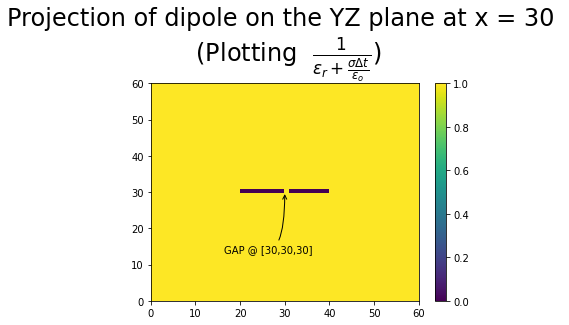

In [11]:
""" fd2d_4_1.py: 3D FDTD
Dipole in free space
"""
import numpy as np
from math import exp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numba

#gridspace
ie = 60
je = 60
ke = 60

ic = int(ie / 2)
jc = int(je / 2)
kc = int(ke / 2)

#field terms
ex = np.zeros((ie, je, ke))
ey = np.zeros((ie, je, ke))
ez = np.zeros((ie, je, ke))
dx = np.zeros((ie, je, ke))
dy = np.zeros((ie, je, ke))
dz = np.zeros((ie, je, ke))
hx = np.zeros((ie, je, ke))
hy = np.zeros((ie, je, ke))
hz = np.zeros((ie, je, ke))

#lossy dielectric terms
gax = np.ones((ie, je, ke))
gay = np.ones((ie, je, ke))
gaz = np.ones((ie, je, ke))

ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size = Cell size / 2*speed of light
epsz = 8.854e-12 #permittivity of free space

# Specify the dipole location and height
hgt = 10 
#Dipole currently at midpoint of grid and of height 2*hgt
gaz[ic, jc, kc - hgt:kc + hgt] = 0
gaz[ic, jc, kc] = 1

#print(np.argwhere(gaz == 0))
plt.pcolormesh(gaz[ic,:,:])
plt.annotate('GAP @ [%d,%d,%d]' %(ic,jc,kc), xy=(jc,kc), xytext=(jc*0.55,kc*0.45),arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))
plt.title('Projection of dipole on the YZ plane at x = %d \n (Plotting  $\\frac{1}{\epsilon_r+\\frac{\sigma\Delta t}{\epsilon_o}}$)' %ic,fontsize=24)
plt.colorbar()
plt.show()

In [44]:
# At each of these time steps, save the E field data
# for plotting at the end (python dictionary(?))
plotting_points = [
{'num_steps': 1, 'data_to_plot': None, 'z_scale': 0.20},
{'num_steps': 4, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 8, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 12, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 16, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 20, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 24, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 28, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 32, 'data_to_plot': None, 'z_scale': 0.5},
{'num_steps': 36, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 40, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 44, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 48, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 52, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 56, 'data_to_plot': None, 'z_scale': 0.05},
{'num_steps': 65, 'data_to_plot': None, 'z_scale': 0.05},
]

len(plotting_points)

16

In [45]:
# Functions for Main FDTD Loop

@numba.jit(nopython=True)
def calculate_d_fields(ie, je, ke, dx, dy, dz, hx, hy, hz):
  """ Calculate the Dx, Dy, and Dz fields """
  for i in range(1, ie):
    for j in range(1, je):
      for k in range(1, ke):
        dx[i, j, k] = dx[i, j, k] + 0.5 * (hz[i, j, k] - hz[i, j - 1, k] -hy[i, j, k] + hy[i, j, k - 1])
  for i in range(1, ie):
    for j in range(1, je):
      for k in range(1, ke):
        dy[i, j, k] = dy[i, j, k] + 0.5 * (hx[i, j, k] - hx[i, j, k - 1] -hz[i, j, k] + hz[i - 1, j, k])
  for i in range(1, ie):
    for j in range(1, je):
      for k in range(1, ke):
        dz[i, j, k] = dz[i, j, k] + 0.5 * (hy[i, j, k] - hy[i - 1, j, k] -hx[i, j, k] + hx[i, j - 1, k])
  return dx, dy, dz

@numba.jit(nopython=True)
def calculate_e_fields(ie, je, ke, dx, dy, dz,gax, gay, gaz, ex, ey, ez):
  """ Calculate the E field from the D field """
  for i in range(0, ie):
    for j in range(0, je):
      for k in range(0, ke):
        ex[i, j, k] = gax[i, j, k] * dx[i, j, k]
        ey[i, j, k] = gay[i, j, k] * dy[i, j, k]
        ez[i, j, k] = gaz[i, j, k] * dz[i, j, k]
  return ex, ey, ez

@numba.jit(nopython=True)
def calculate_h_fields(ie, je, ke, hx, hy, hz, ex, ey, ez):
  """ Calculate the Hx, Hy, and Hz fields """
  for i in range(0, ie):
    for j in range(0, je - 1):
      for k in range(0, ke - 1):
        hx[i, j, k] = hx[i, j, k] + 0.5 * (ey[i, j, k + 1] - ey[i, j, k] -ez[i, j + 1, k] + ez[i, j, k])
  for i in range(0, ie - 1):
    for j in range(0, je):
      for k in range(0, ke - 1):
        hy[i, j, k] = hy[i, j, k] + 0.5 * (ez[i + 1, j, k] - ez[i, j, k] -ex[i, j, k + 1] + ex[i, j, k])
  for i in range(0, ie - 1):
    for j in range(0, je - 1):
      for k in range(0, ke):
        hz[i, j, k] = hz[i, j, k] + 0.5 * (ex[i, j + 1, k] - ex[i, j, k] -ey[i + 1, j, k] + ey[i, j, k])
  return hx, hy, hz


In [87]:
# Pulse Parameters
t0 = 20
spread = 5
nsteps = 100  #number of timesteps
pulse = np.zeros(nsteps)

# Main FDTD Loop
for time_step in range(1, nsteps + 1):
  # Calculate the D Fields
  dx, dy, dz = calculate_d_fields(ie, je, ke, dx, dy, dz, hx, hy, hz)
  # Add the source at the gap
  pulse[time_step-1] = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
  dz[ic, jc, kc] = pulse[time_step-1]
  # Calculate the E field from the D field
  ex, ey, ez = calculate_e_fields(ie, je, ke, dx, dy, dz, gax, gay, gaz, ex, ey, ez)
  # Calculate the H fields
  hx, hy, hz = calculate_h_fields(ie, je, ke, hx, hy, hz, ex, ey, ez)
  # Save data at certain points for later plotting
  for plotting_point in plotting_points:
    if time_step == plotting_point['num_steps']:
      plotting_point['data_to_plot'] = np.copy(ez)

#plt.pcolormesh(dx[ic,:,:])
#plt.colorbar()
#plt.show()

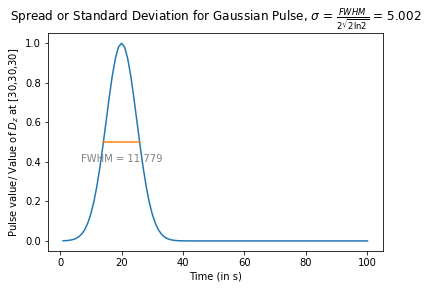

In [98]:
x_axis = np.arange(1,nsteps+1,1)

#https://stackoverflow.com/questions/49100778/fwhm-calculation-using-python 
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),lin_interp(x, y, zero_crossings_i[1], half)]

# find the two crossing points
hmx = half_max_x(x_axis,pulse)

# print the answer
fwhm = hmx[1] - hmx[0]

# a convincing plot
half = max(pulse)/2.0
plt.plot(x_axis,pulse)
plt.plot(hmx, [half, half])
plt.text(t0, half-0.1,'FWHM = %.3f' %fwhm, fontsize=10, color = 'gray', ha='center')
spread_calc = fwhm/(2*np.sqrt(2*np.log(2)))
plt.title('Spread or Standard Deviation for Gaussian Pulse, $\\sigma$ = $\\frac{FWHM}{2\sqrt{2\ln2}}$ = %.3f' %spread_calc)
plt.xlabel('Time (in s)')
plt.ylabel('Pulse value/ Value of $D_z$ at [%d,%d,%d]' %(ic,jc,kc))
plt.show()



Height of dipole at z=0 is 20


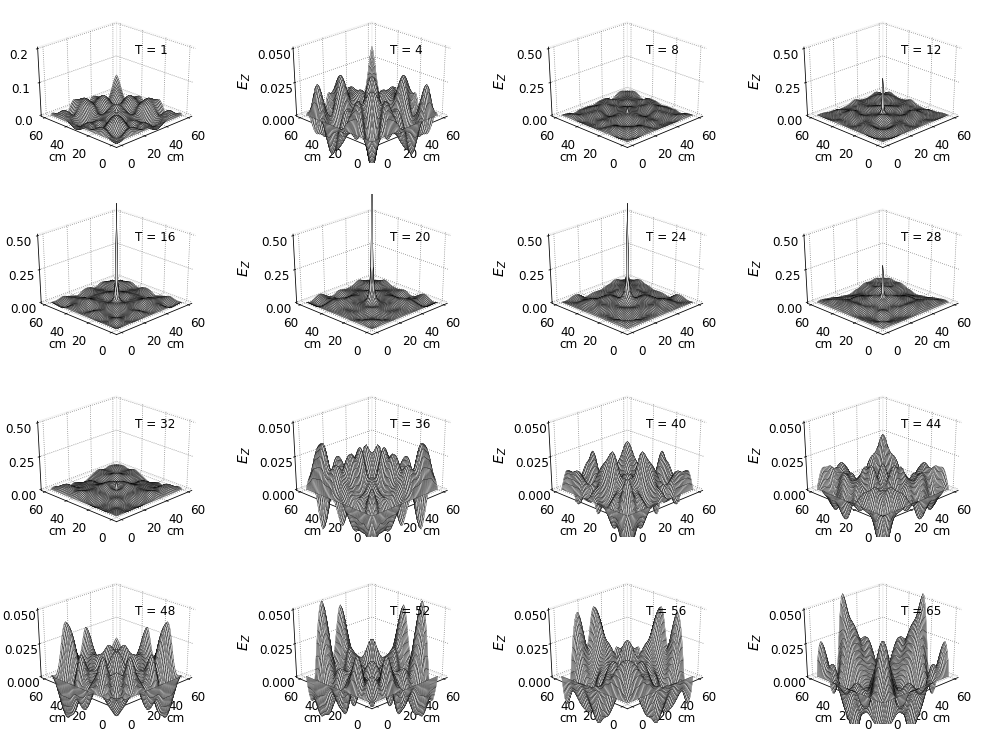

In [99]:
# Plot Fig. 4.3
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(16, 12))

X, Y = np.meshgrid(range(je), range(ie))

def plot_e_field(ax, data, timestep, scale):
  """3d Plot of E field at a single time step"""
  ax.set_zlim(0, scale)
  ax.view_init(elev=30., azim=-135)
  ax.plot_surface(X, Y, data[:, :, kc], rstride=1, cstride=1,
  color='white', edgecolor='black', linewidth=0.25)
  ax.zaxis.set_rotate_label(False)
  ax.set_zlabel(r' $E_{Z}$', rotation=90, labelpad=10, fontsize=14)
  ax.set_zticks([0, scale / 2, scale])
  ax.set_xlabel('cm')
  ax.set_ylabel('cm')
  ax.set_xticks(np.arange(0, ie+1, step=ie/3))
  ax.set_yticks(np.arange(0, je+1, step=ie/3))
  ax.text2D(0.6, 0.7, "T = {}".format(timestep),transform=ax.transAxes)
  ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
  plt.gca().patch.set_facecolor('white')
  ax.dist = 11

# Plot the E field at each of the four time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
  ax = fig.add_subplot(4, 4, subplot_num + 1, projection='3d')
  plot_e_field(ax, plotting_point['data_to_plot'],plotting_point['num_steps'],plotting_point['z_scale'])

print('Height of dipole at z=0 is %d' %(2*hgt))
plt.subplots_adjust(bottom=0.05, left=0.05)
plt.show()

